In [ ]:
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
from datasets import *
from e2c_model import E2C
from train_e2c import evaluate
model = E2C(1600,2,2,'planar').cuda()
model.load_state_dict(torch.jit.load('result/planar/logs/model_2000'))

In [2]:
batch_size = 128
propor = 3/4
dataset = PlanarDataset('./data/planar')
train_set, test_set = dataset[:int(len(dataset) * propor)], dataset[int(len(dataset) * propor):]
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=8)

In [4]:
print(len(test_loader))
state_loss, next_state_loss = evaluate(model, test_loader)
print ('State loss: ' + str(state_loss))
print ('Next state loss: ' + str(next_state_loss))

196
State loss: 11.395704866850647
Next state loss: 7.134127792809306


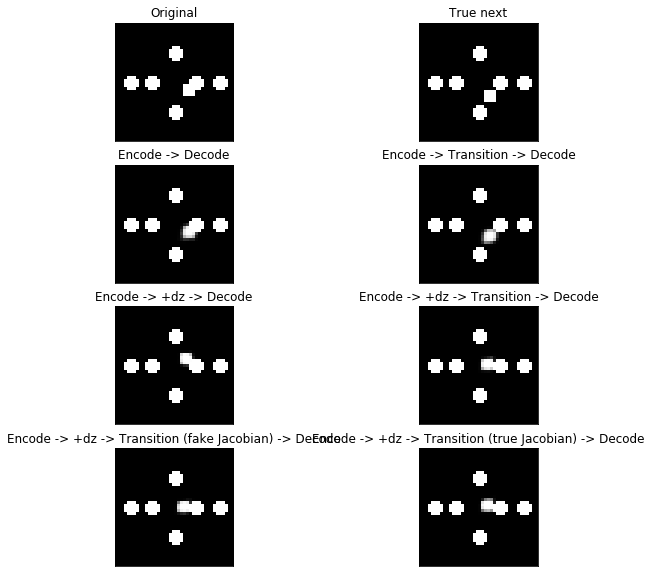

Error (fake Jacobian): 0.028075355546437485
Error (true Jacobian): 0.03323110690101067


In [5]:
from normal import NormalDistribution


rand_idx = random.randint(0, len(test_set))
x, u, x_next = test_set[rand_idx]
with torch.no_grad():
    u_pt = torch.Tensor(u).unsqueeze(0).double().cuda()
    x_recon, x_next_pred, q_z, q_z_next_pred, _ = model(
        x.unsqueeze(0).view(-1,1600).double().cuda(),
        u_pt,
        x.unsqueeze(0).view(-1,1600).double().cuda())
    
    q_z_mean = q_z.mean
    q_z_std = torch.exp(0.5 * q_z.logvar)

    dz = torch.randn(q_z_mean.shape, device='cuda') * 0.3
    q_z_p = NormalDistribution(q_z_mean + dz, q_z.logvar)

    z_p_next_mean_fakejac, _ = model.transition(q_z_mean, q_z_p, u_pt)
    q_z_p_next_mean, _ = model.transition(q_z_p.mean, q_z_p, u_pt)
    z_next_mean, dz_next_mean_jac = torch.autograd.functional.jvp(
        lambda z_ag: model.transition(z_ag, NormalDistribution(z_ag, q_z.logvar), u_pt)[0],
        (q_z_mean,),
        (dz,)
    )
    z_p_next_mean_jac = z_next_mean + dz_next_mean_jac

    x_p = model.decode(q_z_p.mean)
    x_p_next = model.decode(q_z_p_next_mean)
    x_p_next_fakejac = model.decode(z_p_next_mean_fakejac)
    x_p_next_jacpredict = model.decode(z_p_next_mean_jac)

plt.show()
f, axarr = plt.subplots(4,2, figsize=(10,10))
plt.setp(axarr, xticks=[], yticks=[])
axarr[0, 0].imshow(x.squeeze(), cmap='gray')
axarr[0, 1].imshow(x_next.squeeze(), cmap='gray')
axarr[0, 0].set_title('Original')
axarr[0, 1].set_title('True next')

axarr[1, 0].imshow(x_recon.squeeze().view(40, 40).cpu(), cmap='gray')
axarr[1, 1].imshow(x_next_pred.squeeze().view(40,40).cpu(), cmap='gray')
axarr[1, 0].set_title('Encode -> Decode')
axarr[1, 1].set_title('Encode -> Transition -> Decode')


axarr[2, 0].imshow(x_p.squeeze().view(40,40).cpu(), cmap='gray')
axarr[2, 1].imshow(x_p_next.squeeze().view(40,40).cpu(), cmap='gray')
axarr[2, 0].set_title('Encode -> +dz -> Decode')
axarr[2, 1].set_title('Encode -> +dz -> Transition -> Decode')

axarr[3, 0].imshow(x_p_next_fakejac.squeeze().view(40,40).cpu(), cmap='gray')
axarr[3, 1].imshow(x_p_next_jacpredict.squeeze().view(40,40).cpu(), cmap='gray')
axarr[3, 0].set_title('Encode -> +dz -> Transition (fake Jacobian) -> Decode')
axarr[3, 1].set_title('Encode -> +dz -> Transition (true Jacobian) -> Decode')

plt.show()

print("Error (fake Jacobian):", (q_z_p_next_mean - z_p_next_mean_jac).pow(2).sum().sqrt().item())
print("Error (true Jacobian):", (q_z_p_next_mean - z_p_next_mean_fakejac).pow(2).sum().sqrt().item())